# Stroke Prediction
#### Using Deep Neural Networks, Three-Based Metods, and Explainable AI

by ```Eirik Berge```, ```Camilla Idina Jensen Elvebakken```, and ```Martin Ludvigsen```.

## Information About the Data

Stroke is the 2nd leading cause of death globally, and is a disease that affects millions of people every year:

<a href=https://en.wikipedia.org/wiki/Stroke>Wikipedia - Stroke </a>

In this project, we will attempt to classify stroke patients using a dataset provided on Kaggle: 

<a href=https://www.kaggle.com/fedesoriano/stroke-prediction-dataset >Kaggle Stroke Dataset</a>

The dataset consists of over $5000$ individuals and $10$ different input variables that we will use to predict the risk of stroke. The input variables are both numerical and categorical and will be explained below. Some input variables are known risk factors for stroke, like <a href=https://en.wikipedia.org/wiki/Hypertension>hyptertension</a> (high blood pressure) and smoking status. In addition, the data set includes some variables that may not traditionally be considered as risk factors: work type and residence type. 

The source and collection methods for the dataset is confidential. In particular, we do not know which countries the participants come from, or if the data originates from medical records or somewhere else. This is problematic as many of the variables are categorical, and it is unclear exactly how the categories were determined or if the different categories were measured at the same time. Notably, it is not clear what type of stroke the dataset is concerned with. One usually subdivides stroke into two categories: Ischemic stroke, which is when the blood supply to the brain is interrupted, and hemorrhagic stroke, which is in part caused by rupturing blood vessels. The fact that the source of the data is confidential also makes it difficult to assess the quality of the data. Another problem with the data is that it is very unbalanced, as there are many more patients without stroke than with stroke. We will attempt to tackle some of these problems in this report.

In this report we will mainly attempt different tree-based methods like random forests and boosting and simple neural networks. We will also spend some time exploring parameter tuning, where we will attempt both gridsearch and Bayesian optimization in order to locate optimal hyperparameters. 

## More on the Different Variables
The dataset contains the following data:

- ```id``` - Integer
- ```gender``` - Categorical: ```male```, ```female``` or ```other```
- ```age``` - Float
- ```hypertension``` - Categorical: ```1``` or ```0```
- ```heart_disease``` - Categorical: ```1``` or ```0```
- ```ever_married``` - Categorical: ```1``` or ```0```
- ```work_type``` - Categorical: ```Private```, ```Self-employed```, ```Govt-job```, ```Never_worked```, ```children```
- ```Residence_type``` - Categorical: ```Urban```, ```Rural```
- ```avg_glucose_level``` - Float
- ```bmi``` - Float
- ```smoking_status``` - Categorical: ```never smoked```, ```formerly smoked```, ```smoking```, ```unknown```
- ```stroke``` - Categorical: ```1``` or ```0```

The variable ```hypertension``` is given as a categorical variable instead of a numerical value containing systolic and diastolic blood pressures. What is considered hypertension depends on age, so having hypertension as a categorical variable might remove the dependency between blood pressure and age, which can make it easier to fit useful models. However, we do not know if hypertensionis determined in a consistent way for all patients, and whether having blood pressure as a float would be more useful. For both hypertension and heart disease, we have no information about the severity of the condition, which is a downside of having only two categorical variables.

On the contrary, ```avg_glucose_level``` and ```bmi``` are given as floats, whereas they could have been encoded as categorical variables like hyperglycemia (<a href=https://en.wikipedia.org/wiki/Hyperglycemia>Wikipedia - Hyperglycemia</a>) and different stages of underweight/overweight, which differs based on age and gender. 

As for ```stroke```, we have no information about what type of stroke the patient suffered from, as we have already mentioned. In addition, we do not have information about the severity of the stroke, or if the patient died directly or indirectly from the stroke.

For the categorical variables ```work_type```, ```ever_married```, ```Residence_type```, and ```smoking_status```, it is uncertain if the categories yield anything more than noise, and if they are useful for predicting stroke. In particular, the categories are not particularly sharp. For example, we do not know the "boundary" between urban and rural residence, or if the patient is currently employed or how long they have been in their current line of work. Smoking status is the only one of these variables that are known to be an important risk factor for stroke. It is therefore problematic that one of the ```smoking_status``` categories is ```unknown```. Keeping the data where smoking status is unknown adds more noise to our data, which can make fitted models less effective. We have a few options for handling this:

- We could remove all the data where smoking status is unknown, which should not be problematic if relatively few patients have unknown smoking status. 

- We could remove the smoking status variable altogether from all patients, which might be helpful if smoking status proves to be noisy.

- We could keep the data as is, and hope the added information of smoking status for some patients outweighs the noise of the patients where smoking status is unknown.

In this report, we choose the last approach. If anything, the problems with the data illustrate the importance of high-quality data collection. 

## Importing Packages

We are going to use various packages, and import them collectively here for convenience.

In [1]:
# Data Handling
import numpy as np
import pandas as pd

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Utilities
from skopt.space import Real, Categorical, Integer

# Basic Machine Learning
import xgboost as xgb
from skopt import BayesSearchCV
from pdpbox import pdp, get_dataset, info_plots
from lime.lime_tabular import LimeTabularExplainer
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve,
                             auc, precision_recall_curve, make_scorer, confusion_matrix, plot_roc_curve)
# Deep Learning
from tensorflow import keras
from tensorflow.keras.optimizers import SGD

## Cleaning the Data

We start by cleaning the data and we create dummy variables for some of the variables in the dataset. The data is finally stored in a new CSV-file called ```stroke_clean.csv```.

In [2]:
# Loading in the dataset with Pandas
stroke = pd.read_csv('stroke.csv')

# View the first 3 rows of the dataset
stroke.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


There is already an ```id``` column, so there is no need for a separate index. Hence we make the ```id``` column the index of the dataframe.

In [3]:
# Make the id column the index of the DataFrame
stroke.index = stroke['id']
del stroke['id']

# Make all the column names lowercase
stroke.columns = stroke.columns.str.lower()

The following cell shows that there are some missing values in the ```bmi``` column. Since this is only roughly 4% of the observables, we remove these persons completely.

In [4]:
# Find out where the are missing values
print(stroke.isnull().any())

# Determine the number of missing values
missing_values = stroke['bmi'].isnull().sum()
print(f'\nThere are {missing_values} missing values in the bmi column\n')

# Drop the rows with the missing values
stroke.dropna(inplace=True)

# Check out the datatypes of the data
print(stroke.info())

gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

There are 201 missing values in the bmi column

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4909 non-null   object 
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   int64  
 3   heart_disease      4909 non-null   int64  
 4   ever_married       4909 non-null   object 
 5   work_type          4909 non-null   object 
 6   residence_type     4909 non-null   object 
 7   avg_glucose_level  4909 non-null   float64
 8   bmi                4909 non-null   float64
 9 

We also see that the columns ```gender```, ```ever_married```, ```work_type```, ```residence_type```, and ```smoking_status``` are of data type <i>object</i>. Let us investigate these columns to see if it is reasonable to convert them to a numeric format.

### Gender

In [5]:
# Check the values present in the gender column
stroke['gender'].value_counts()

Female    2897
Male      2011
Other        1
Name: gender, dtype: int64

Since there is only one <i>Other</i>, this will not give us anything statistically significant. 

In [6]:
# Removal of "other"
stroke.drop(stroke[stroke['gender'] == 'Other'].index[0], inplace=True)

# Do a dummy encoding of the genders
stroke['gender'].replace({'Female': 1, 'Male': 0}, inplace=True)

It is interesting to note that more men than women had strokes, even though the average age of women in the study is higher than men.

In [7]:
# More men than women had strokes
stroke.groupby('gender').mean()[['age', 'stroke']]

,age,stroke
gender,,
0,42.049130,0.044257
1,43.437805,0.041422


### Ever Married

In [8]:
# Check the values present in the ever_married column
stroke['ever_married'].value_counts()

Yes    3204
No     1704
Name: ever_married, dtype: int64

Here we only have two categories, and we perform a dummy encoding.

In [9]:
# Do a dummy encoding of the ever_married column
stroke['ever_married'].replace({'Yes': 1, 'No': 0}, inplace=True)

### Work Type

In [10]:
# Check the values present in the ever_married column
stroke['work_type'].value_counts()

Private          2810
Self-employed     775
children          671
Govt_job          630
Never_worked       22
Name: work_type, dtype: int64

Since there are 5 categories, we dummy encode them into new columns.

In [11]:
# Dummy encoding into 5 columns
dummy_variables = pd.get_dummies(stroke['work_type'])
del stroke['work_type']
 
# Assign new columns to the dataframe
stroke['govt_job'] = dummy_variables['Govt_job']
stroke['never_worked'] = dummy_variables['Never_worked']
stroke['private'] = dummy_variables['Private']
stroke['self-employed'] = dummy_variables['Self-employed']
stroke['children'] = dummy_variables['children']

### Residence Type

In [12]:
# Check the values present in the residence_type column
stroke['residence_type'].value_counts()

Urban    2490
Rural    2418
Name: residence_type, dtype: int64

There are two categories with very similar amounts. We again perform a dummy encoding.

In [13]:
# Do a dummy encoding of the residence_type column
stroke['residence_type'].replace({'Urban': 1, 'Rural': 0}, inplace=True)

### Smoking Status

In [14]:
# Check the values present in the smoking_status column
stroke['smoking_status'].value_counts()

never smoked       1852
Unknown            1483
formerly smoked     836
smokes              737
Name: smoking_status, dtype: int64

Notice that for a lot of the smoker, we only have the status <i>Unknown</i> to work with. Since there is so many of them, we have chosen to not drop the observables. We again perform a dummy encoding.

In [15]:
# Dummy encoding into 4 columns
dummy_variables = pd.get_dummies(stroke['smoking_status'])
del stroke['smoking_status']

# Assign new columns to the dataframe
stroke['never_smoked'] = dummy_variables['never smoked']
stroke['formerly_smoked'] = dummy_variables['formerly smoked']
stroke['smokes'] = dummy_variables['smokes']
stroke['unknown_smoker'] = dummy_variables['Unknown']

Finally, we reorder the columns so that ```stroke```, namely the variable we try to predict, is last.

In [16]:
# Reordering columns
labels = list(stroke.columns)
labels.append('stroke')
del labels[8]
stroke = stroke.reindex(columns=labels)

We save the cleaned data in a CSV file called ```stroke_clean.csv```.

In [17]:
# Saving the data.
stroke.to_csv('stroke_clean.csv')

## Exploratory Data Analysis

Before we start to develop various models, we explore the data to find trends and skewness to keep in mind later. Let us first see how many of the patients have had a stroke:

In [18]:
# Loading back in the cleaned data
stroke_clean = pd.read_csv('stroke_clean.csv', index_col='id')

# Printing out stroke-percentages
print("Percentage of stroke: ", np.round((stroke_clean[stroke_clean.stroke == 1].shape[0]/stroke_clean.shape[0]) * 100, 2), "%")
print("Percentage of non-stroke: ", np.round((stroke_clean[stroke_clean.stroke == 0].shape[0]/(stroke_clean.shape[0]) * 100), 2), "%")

Percentage of stroke:  4.26 %
Percentage of non-stroke:  95.74 %


As we can see above, about 95.7% have not had a stroke. We see that the class distribution is very skewed, which will make this a hard problem, as the model must be sensitive enough to capture the trends of the minority class. We try looking at the stroke distribution among some of the other features in the dataset. 

Text(0.5, 1.0, 'Age/stroke distribution')

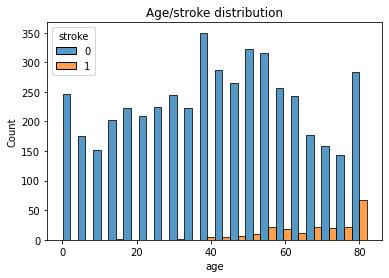

In [19]:
# Visualize the age of people with stroke versus people without stroke
sns.histplot(
    data=stroke_clean,
    x="age", 
    hue="stroke", 
    multiple="dodge"
).set_title("Age/stroke distribution")


We see that more old people than young people have strokes, while we seem to have a good representation of all ages in the dataset. Hence it seems that ```age``` will be an important predictor for predicting ```stroke```.

For the ```smoker``` variable, we have pointed out previously that we are lacking some information due to the <i>Unknown</i> option. We now display how many we are missing

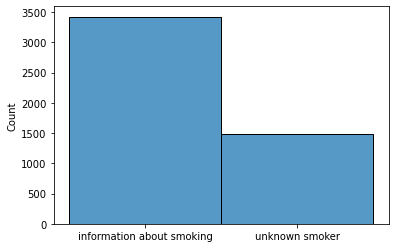

In [20]:
# Show how much information we have about smokers.
information_about_smoker = np.where(stroke_clean.unknown_smoker == 1, "unknown smoker", "information about smoking")
sns.histplot(data=information_about_smoker)
plt.show()

We see that almost one third of our data has smoking status unknown. This is a lot of data, so we coose to include the data with unkown smoking status in our analysis. 

We end this section by showing a heatmap of the correlation between the different variables.

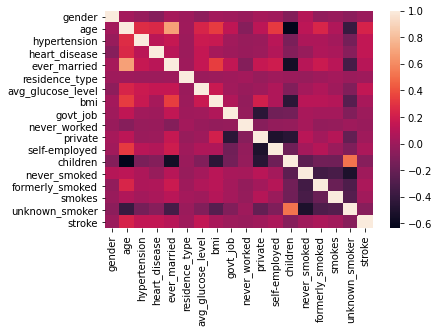

In [21]:
# Correlation heatmap
sns.heatmap(stroke_clean.corr())
plt.show()

We see from the heatmap above that the response ```stroke``` does not seems particularily correlated with any of the predictors. Thus the choice of non-linear models such as ensembles and neural networks is well motivated. When using methods with the assumtion that the features are independent we have to be careful though - many of the features are highly correlated with each other, for example ```age```, ```ever_married``` and ```children```.

## Utility Functions

Below we define three utility functions that we will use over and over again later in the document:

In [22]:
# Necessary functions for evaluating models

def curves(model_fit, x_test, y_test):
    baseline_probs = [0 for _ in range(len(y_test))]
    probs = model_fit.predict_proba(x_test)[:, 1]

    # calculate scores
    baseline_auc = roc_auc_score(y_test, baseline_probs)
    pc_auc = roc_auc_score(y_test, probs)

    # calculate roc curves
    baseline_fpr, baseline_tpr, _ = roc_curve(y_test, baseline_probs)
    fpr, tpr, thresholds = roc_curve(y_test, probs, drop_intermediate = False)
    
    fig, axs = plt.subplots(1, 2, figsize=(13, 5))
    
    axs[0].plot(baseline_fpr, baseline_tpr, linestyle = "--", color = "lightgrey")
    axs[0].plot(fpr, tpr, marker = ".", label = "ROC AUC=%.3f" % (pc_auc), color = "orange")
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].set_title("ROC Curve")
    axs[0].legend()
    
    # Calculating precision-recall curves
    probs = model_fit.predict_proba(x_test)[:, 1]
    
    # predict class values
    precision, recall, _ = precision_recall_curve(y_test, probs)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    
    yhat = model_fit.predict(x_test)
    model_f1, model_auc = f1_score(y_test, yhat), auc(recall, precision)
    
    axs[1].plot([0, 1], [no_skill, no_skill], linestyle='--', color = "lightgray")
    axs[1].plot(recall, precision, marker=".", label="f1=%.3f auc=%.3f" % (model_f1, model_auc), color = "orange")
    axs[1].set_xlabel("Recall")
    axs[1].set_ylabel("Precision")
    axs[1].set_title("Precision-Recall Curve")
    axs[1].legend()
    
    plt.show()

def train_error(model_fit, X_train, y_train):
    train_pred = model_fit.predict(X_train)

    print("Train errors:")
    print()
    print("accuracy: %.3f" % accuracy_score(y_train, train_pred))
    print("precision: %.3f" % precision_score(y_train, train_pred, zero_division = 0))
    print("recall: %.3f" % recall_score(y_train, train_pred, zero_division = 0))
    print("f1: %.3f" % f1_score(y_train, train_pred, zero_division = 0))
    print()
    
def test_error(model_fit, X_test, y_test):
    test_pred = model_fit.predict(X_test)

    print("Test errors:")
    print()
    print("accuracy: %.3f" % accuracy_score(y_test, test_pred))
    print("precision: %.3f" % precision_score(y_test, test_pred, zero_division = 0))
    print("recall: %.3f" % recall_score(y_test, test_pred, zero_division = 0))
    print("f1: %.3f" % f1_score(y_test, test_pred, zero_division = 0))

    cm_test = confusion_matrix(y_test, test_pred)
    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = ["{0:0.0f}".format(value) for value in cm_test.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm_test, annot=labels, fmt = "", annot_kws={"size": 16}, linewidths = 0.5, cmap="YlGnBu")

## Two Simple Models

To benchmark more complicated models, we have chosen to start with two simple models: A logistic regression model and a simple deep neural network. Let us begin by splitting the data:

In [23]:
# Split into data and response
predictors = stroke_clean.drop('stroke', axis=1)
response = stroke_clean.stroke

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    predictors, 
    response, 
    test_size=0.25,
    random_state=0
)

### Logistic Regression (with Ridge Penalty)

We use the function ```LogisticRegressionCV``` in the package ```scikit-learn``` to perform a simple logistic regression with Ridge penalty and some cross-validation. We also set the class_weight to <i>balanced</i>. Using the keyword <i>balanced</i> the method will automatically adjust weights which are inversely proportional to the class frequencies in the input data. We will get back to this more with random forests.

One of the nice things about logistic regression is that we only need to tune the ridge parameter, which is done a lot more effectively than the parameter tuning for the other methods.

In [24]:
# Add Ridge regression with parameter chosen by 10-fold CV
logregfit = LogisticRegressionCV(random_state=0, max_iter=1000, cv=10, class_weight="balanced").fit(X_train, y_train)

# Obtain the coefficients in a table
table_of_coefficients = pd.DataFrame(X_train.columns)
table_of_coefficients["Coefficients"] = logregfit.coef_.transpose()
table_of_coefficients.head()

,0,Coefficients
0,gender,0.086482
1,age,0.079610
2,hypertension,0.613706
3,heart_disease,0.244234
4,ever_married,-0.030365


The basic accuray of the logistic model is reported below on both the training set and the test set. As can be seen, we obtain better test accuracy than training accuracy, and both are very high already.

In [25]:
print("Train accuracy: ", logregfit.score(X_train, y_train))
print("Test accuracy: ", logregfit.score(X_test, y_test))

Train accuracy:  0.7468079326270035
Test accuracy:  0.7302363488182559


We now plot the ROC curve and the Precision-Recall Curve for the logistic regression.

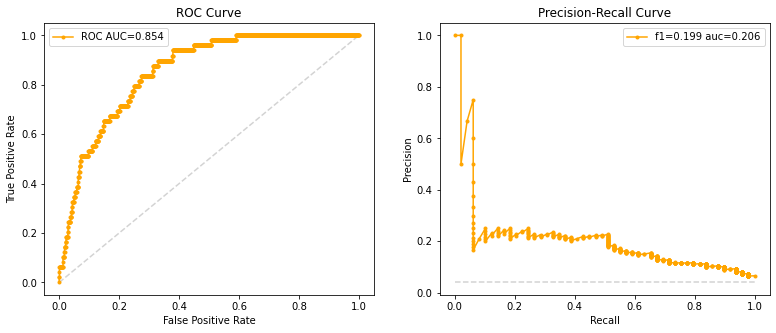

In [26]:
# Plotting the curves
curves(logregfit, X_test, y_test)

Test errors:

accuracy: 0.730
precision: 0.113
recall: 0.837
f1: 0.199


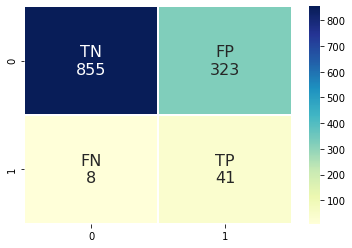

In [27]:
# Displaying test-errors
test_error(logregfit, X_test, y_test)

Investigating the ROC-curve we see that even when using the "balanced" weighting the curve is skewed towards the upper right, indicating that true positives comes heavily at the cost of false positives. This is mainly because our dataset is unbalanced, and we will see this trend for essentially all models.

### A Simple Deep Neural Network

We also investigate the effectiveness of a simple deep neural network. To do this, we use the package ```keras```. We begin by scaling the data and making the various layers in the neural network.

In [65]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Making the layers
model = keras.models.Sequential([
    keras.layers.Input(shape=[17]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(1, activation="sigmoid")
])

# Checking out the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               1800      
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 12,001
Trainable params: 12,001
Non-trainable params: 0
_________________________________________________________________


Below we compile and fit the neural network. Note that we have made a weight called ```class_weight``` that ensures that the model focus on classifying the true positives correctly, with the understanding that this will most likely cause the false-positive rate to also increase.

In [66]:
# Compiling the model
model.compile(
    loss="binary_crossentropy",
    optimizer='SGD',
    metrics=[
        keras.metrics.Recall(), 
        keras.metrics.Precision(), 
        'accuracy'
    ]
)

# Choosing a weight
class_weight = {0: 1., 1: 22.}

# Fitting the model
model.fit(X_train_scaled, y_train, class_weight=class_weight, epochs=5)

Epoch 1/5
116/116 [==============================] - 0s 1ms/step - loss: 1.3067 - recall_1: 0.5813 - precision_1: 0.0548 - accuracy: 0.5463  
Epoch 2/5
116/116 [==============================] - 0s 1ms/step - loss: 1.1727 - recall_1: 0.6438 - precision_1: 0.0816 - accuracy: 0.6697  
Epoch 3/5
116/116 [==============================] - 0s 1ms/step - loss: 1.1406 - recall_1: 0.7250 - precision_1: 0.0909 - accuracy: 0.6729  
Epoch 4/5
116/116 [==============================] - 0s 1ms/step - loss: 1.0846 - recall_1: 0.7250 - precision_1: 0.1025 - accuracy: 0.7120  
Epoch 5/5
116/116 [==============================] - 0s 1ms/step - loss: 1.0408 - recall_1: 0.7500 - precision_1: 0.1069 - accuracy: 0.7167


We have made a model that emphasizes maximizing recall. This comes, due to the skewness of our data, at the cost of having low accuracy and horrible precision. Such a model can be useful as a preliminary test, where one gets many fasle positves but catches most true positives.

In [67]:
# Testing the model
results = model.evaluate(X_test_scaled, y_test)

print("\nRecall: ", round(results[1], 3))
print("Precision: ", round(results[2], 3))
print("Accuracy: ", round(results[3], 3))

39/39 [==============================] - 0s 767us/step - loss: 0.5366 - recall_1: 0.8367 - precision_1: 0.1139 - accuracy: 0.7335

Recall:  0.837
Precision:  0.114
Accuracy:  0.733


Instead of applying neural networks, we will attempt to apply tree-based methods. Before we do so, we have to discuss how to evaluate performance of our methods.

## Discussion on Evaluating Performance and Hyperparameters

### Evaluating Performance

The skewness in the data for the response is typical in medical datasets that deals with prediction of rare occurrences like stroke. We will always have many more examples of people without the condition, than with, making it very dificult to correctly identify the general pattern behind the minority class. In addition, with skewed medical datasets like this one, false negative rates and false positive rates do not have equal weight. In our dataset, a false negative will be much more dangerous than a false positive, as it is better to predict that someone will get a stroke and get it wrong, than the other way around.

For binary classification problems it is typical to use accuracy as the metric to evaluate performance of the method. Accuracy is the ratio of the correctly predicted observations to the total number of observation. With an imbalanced problem like the one we have, accuracy will not be a good preformance measure. To show why, if we simply make a classification model which predicts all observations as class 0, "no stroke", we will get a very high accuracy which will not reflect the difference in size between the two classes.

\begin{align*}
    \text{accuracy} = \frac{\text{tp + tn}}{\text{tp + tn + fn + fp}} = \frac{4699 + 0}{4699 + 0 + 209 + 0} = 0.957
\end{align*}

Other measures which are better with dealing with unsymmetric classes are precision and recall. Precision is the ratio of correctly predicted positive observations to the total number of predicted positive observations. Precision favors a low false positive rate. Recall is the ratio of correctly predicted positive observations to all the observations in the actual class. This favors the false negative rate, which is important when we want to minimize the number of false negatives. Both of these metrics would becomes zero in the case above.

\begin{align*}
    \text{precision} = \frac{\text{tp}}{\text{tp + fp}}, \quad \text{recall} = \frac{\text{tp}}{\text{tp + fn}}
\end{align*}

To be able to take into account both recall and precision, we can use the f1-measure, which is the harmoic mean of precision and recall:

\begin{align*}
    \text{f1} = \frac{2\cdot \text{precision} \cdot \text{recall}}{\text{precision + recall}}
\end{align*}

Instead of using the predicted values from using the threshold 0.5, we could also calculate both ROC-AUC and precision-recall-AUC to find better thresholds. ROC-AUC is the area under the ROC curve which plots the true positive rate against the false positive rate. The precision-recall curve uses precision instead of false positive rate, and can be considered better in the case when we have an unproportional large amount of true negatives, since neither recall or precision takes this into account.

Sklearn also icludes several metric which tries to balance out the classes during evaluation. For evaluating our models we will use the balanced accuracy score, which is defined as the average of recall obtained on each class: 

<a href=https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html>Scikit-Learn - Balanced Accuracy </a> 

We will show this produces good results. Using this metric during the hyperparameter tuning of the models, the goal is that the models will favor decreasing the amount of false negatives over increasing the amount of true negatives. This might push more observations into false positives, but considering the real world implications of false negatives in stroke predictions, this is an acceptable trade-off.

### Hyperparameter tuning

Most of the models we will apply will need some hyperparameter tuning in order to be effective. Hyperparameters are essentially all parameters that we pass to the function that fits a model. What we consider hyperparameters will become evident when discussing the different models. The goal of hyperparameter tuning is to select hyperparameters so that the model maximizes some metric. For essentially all models we use the "balanced_accuracy" metric for tuning our models. 

In statistical learning and machine learning, the the hope is that most model are stable in the hyperparameters, meaning that small changes in hyperparameters yield similar results. This is however not always the case, and hyperparameter tuning is necessary.

Different hyperparameters also allow us to tune models to be more balanced. However, we will see that in order to get good results for this problem, one should start with a balanced model instead of tuning an unbalanced model to be more balanced. 

Hyperparameter tuning is a difficult optimization problem. It is difficult because we usually have no mathematical expression for how different hyperparameters affect the metric. This means that we have no information about gradients, and the problem is most likely non-convex. Furthermore, function evaluations, which here corresponds to fitting a model with certain hyperparameters, are usually expensive. For tree-models, many hyperparameters are discrete, and if we change one hyperparameter we usually have to refit the entire model. This is different from for example lasso regression, where model fits are (usually) continuous with respect to the regularization parameter, and one fit can be used to quickly find the next fit. This is also the case for some tree-model hyperparameters, but this is not necessarily taken into account by the methods we use to search for hyperparameters. 

We will use two different methods for hyperparameter tuning: Grid search and Bayesian search. 
Grid search fits models using a grid of hyperparameters, at each point applying CV to get an estimate of the metric, and selects the model that gives the best result. 

- Grid search is simple, easy to parallelize and requires essentially no cost other than fitting the models.
- One of the drawbacks is that we have to preselect a grid, which can either be too coarse, leading to a bad result, or too fine, leading to long computation times. 
- Another problem with preselecting a grid is that the optimal hyperparameters do not necessarily lie inside the preselected grid, meaning that grid search is not entirely automatic.

The grid search we will use is the ```GridSearchCV``` function in the sklearn library. 

Bayesian search uses Bayesian optimization to find optimal hyperparameters. We will not go into detail about Bayesian optimization here, but we will mention some pros and cons. 

- The main appeal of Bayesian optimization is that it searches for a good solution in a much smarter way than grid search. 
- It is able to handle local minimizers, which is something traditional optimization methods usually struggle with.
- We can select prior distributions for the hyperparameters, and the result can be considered a posterior distribution. Thus, we can actually do some inference with our hyperparameters.
- The implementation that we will use, ```BayesianSearchCV``` from the scikit optimize library, is currently under development, and not particularily fast or well-documented. The extra cost of searching for good hyperparameters to test most likely outweigh the cost of just testing more "bad" hyperparameters, which is especially the case if fitting the models is cheap. 
- Bayesian optimization is also mainly effective for continuous, not discrete, variables. It is unknown to us how the implementation we use handles discrete variables. Bayesian optimization also has the problem of requiring a preselected grid where we search for solutions.

For both grid search and Bayesian search, the implementations we are using are rather lacking in that it is difficult to interpret the results. It is not impossible, but it requires some extra work that we are not interested in doing here. It would be interesting to investigate how stable different methods are with respect to different hyperparameters and which hyperparameters are important.

## Tree-Based Models

We now test various tree-based methods to see how they perform. We begin with a simple decision tree.

### Decision tree

For tree-based models, we start by implementing a simple decision tree to get a baseline test error for our models to see if the more advanced ensemble methods and the neural network can actually improve predictions for this very imbalanced dataset. To search for the optimal hyperparameters we use a gridsearch using sklearn's ```GridSearchCV```. To use this method we must define a grid of hyperparameter values for the method to test.  For the decision tree we decide to include the hyperparamters ```criterion```, ```max_depth```, ```min_samples_split``` and ```min_samples_leaf```. There are more hyperparameters to tune, and we are not certain if these are the best parameters to tune. In fact, the more parameters we tune, the more likely it is that we do a lot of unecessary calculations.

We will first implement the decision tree using accuracy as the scoring metric, to show that this does not yield optimal results.

In [ ]:
# Setting up parameters
parameters = {
    "criterion": ["gini", "entropy"], 
    "max_depth": range(1, 8),          
    "min_samples_split": range(2, 8),
    "min_samples_leaf": range(1, 8)
    }

# Creating the decision tree
decisiontree = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=23),
    param_grid=parameters,
    scoring="accuracy",
    cv=3
)

# Fit the desicion tree
decisiontree_fit = decisiontree.fit(X_train, y_train)

# Print out the best parameters
print("Best hyperparameter:")
print(decisiontree_fit.best_params_)

We see that the best hyperparameters yield an extremely shallow tree with a maximum depth of 1. From the resulting decision tree above we see that the tree does not manage to correctly classify many of the observations from the minority class. We calculate the test error below.

In [ ]:
# Display test error statistics
test_error(decisiontree_fit, X_test, y_test)

From the confusion matrix above we see that the method does not manage to predict a single true positive case, but still gets a accuracy of $\sim 96\%$. As the good statisticians we are, we are not fooled by the good accuracy, and try use the "balanced accuracy" as the scoring metric in the hyperparameter tuning from now on.

For each model we also plot the ROC and precision-recall curves to see how these changes with the different methods. When using a different metric we expect the ROC-AUC score to becomes worse, but hopefully the PR-AUC score will increase.

In [ ]:
# Plot ROC and Precision-Recall Curve
curves(decisiontree_fit, X_test, y_test)

We train the decision tree again, this time with the "balanced accuracy" score. We also allow the ```class_weight``` to be "balanced" in out hyperparameter tuning.

In [ ]:
# Setting up parameters
parameters = {
    "criterion": ["gini", "entropy"], 
    "max_depth": range(1, 8),
    "min_samples_split": range(2, 8),
    "min_samples_leaf": range(1, 8),
    "class_weight": [None, "balanced"]
}

# Creating the decision tree
balanced_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=23),
    param_grid=parameters,
    scoring="balanced_accuracy", 
    cv=3
)

# Fit the desicion tree
balanced_tree_fit = balanced_tree.fit(X_train, y_train)

# Print out the best parameters
print("Best hyperparameters:")
print(balanced_tree_fit.best_params_)

In [ ]:
# Display test error statistics
test_error(balanced_tree, X_test, y_test)

In [ ]:
# Plot ROC and Precision-Recall Curve
curves(balanced_tree, X_test, y_test)

Using the different scoring metric, we have managed to get a better recall, at the expense of many more false positive predictions and a much lower accuracy. Being able to classify true positives comes heavily at the cost of producing false positives.

### Random Forests

Instead of using a single decision tree, we instead try a random forest model. Random Forest is a modification of bagging which tries to reduce the variance further by decreasing the correlation between the trees by including randomness in which features to consider for each split in each tree. The hyperparameters we will tune are the number of trees in the forest, ```n_estimators```, the number of features to consider in each split, ```max_features```, and the ```max_depth``` of the trees. In this case, we look at a sparser grid of hyperparameters. As the number of hyperparameters increase, the number of fits required by a grid search increases quickly. In this example, we have to test $360$ different fits.

In [ ]:
# Setting up parameters
parameters = {
    'criterion': ['gini', 'entropy'], 
    'n_estimators': [1, 5, 10, 30, 50, 100],
    'max_features': ('sqrt', 8, 12),
    'max_depth': range(1, 10)
}

# Creating the random forest
randomforest = GridSearchCV(
    estimator=RandomForestClassifier(random_state = 23, bootstrap = True),
    param_grid=parameters,
    scoring="balanced_accuracy",
    cv=3
)

# Fit the random forest
randomforest_fit = randomforest.fit(X_train, y_train)

# Print out the best parameters
print("Best hyperparameters:")
print(randomforest_fit.best_params_)

In [ ]:
# Display test error statistics
test_error(randomforest, X_test, y_test)

In [ ]:
# Plot ROC and Precision-Recall Curve
curves(randomforest, X_test, y_test)

From the results above we see that the random forest does not work exactly as we hoped. From the cross-validation grid search we see that the model favors only a single decision tree, which is deep and includes the choice of many features for each split. The reason why the method fails is probably because it is hard to find a shallow tree which manages to predict anything other than the majority class. 

During the bootstrapping procedure, we expect even fewer examples from the minority class to be present during the fitting of the model. This is probably why the model fails and would rather build fewer deeper trees, than a whole forests of small ones. This shows that we cannot tune an unbalanced model to become balanced. The method needs to be balanced to begin with. This motives the use for better sampling during the bootstrap which leads to weighted random forest and balanced random forest.

### Weighted Random Forest

From the above result it is obvious that we have to change the random forest algorithm to make it more sensitive towards misclassifications of the minority class. One way to do this is by giving the different classes different weights when calculating the gini impurity score at each split. This way the model becomes better at making splits which favors correctly classifying the minority class. Sklearn's implementation of random forest includes the parameter class_weight which can be used for this purpose. As mentioned earlier we can use the ```class_weight``` "balanced" in this case. Since we are using bootstrap samples we can also use the keyword "balanced_subsample" which computes the weights based on the distribution of the classes in each bootstrap sample.

In [ ]:
# Setting up parameters
parameters = {
    'n_estimators': [1, 10, 30, 50, 100],
    'max_features': ('sqrt', 8, 12),
    'max_depth': range(1, 10),
    'class_weight': ["balanced", "balanced_subsampled"]
}

# Creating the weighted random forest
weighted_forest = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state=23, 
        criterion='gini',
        bootstrap=True
    ),
    param_grid=parameters,
    scoring="balanced_accuracy",
    n_jobs=8,
    cv=3
)

# Fit the weighted random forest
weighted_forest_fit = weighted_forest.fit(X_train, y_train)

# Print out the best parameters
print("Best hyperparameters:")
print(weighted_forest.best_params_)

In [ ]:
# Display test error statistics
test_error(weighted_forest, X_test, y_test)

In [ ]:
# Plot ROC and Precision-Recall Curve
curves(weighted_forest, X_test, y_test)

Using the Weighted Random Forest we achieve much better results than the non-balanced random forest. We see that we have managed to decrease the number of false negatives significantly, but as a result the number of false positives has increased.

### Balanced Random Forest

Another method we can use to make the random forest more sensitive to the minority class is to use under-/oversampling during the bootstrap sampling. Oversampling works by sampling more observation from the minority class by either duplicating or creating new synthetic observations, such that the occurrence of minority observations is more balanced compare with the majority class. Undersampling works by deleting or merging examples in the majority class. 

The Python library imbalanced-learn offers a number of resampling techniques which can be used in datasets showing strong imbalance. It includes an implementation of the Balanced Random Forest methods, which works by randomly undersampling from the majority class during the bootstrap sampling:

<a href=https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html> Balanced Random Forests Classifier </a>

We hope that this will bring an even bigger improvement to the method than using the Weighted Random Forest.

In [ ]:
# Setting up parameters
parameters = {
    'n_estimators': [1, 10, 30, 50, 100],
    'max_features': ('sqrt', 8, 12),
    'max_depth': range(1, 10),
    'class_weight': [None, "balanced", "balanced_subsampled"]
}

# Creating the balanced random forest
balanced_forest = GridSearchCV(
    estimator=BalancedRandomForestClassifier(
        random_state=23,
        criterion='gini',
        bootstrap=True
    ),
    param_grid=parameters,
    scoring="balanced_accuracy",
    n_jobs=8, 
    cv=3
)

# Fit the weighted random forest
balanced_forest_fit = balanced_forest.fit(X_train, y_train)

# Print out the best parameters
print("Best hyperparameters:")
print(balanced_forest.best_params_)

In [ ]:
# Display test error statistics
test_error(balanced_forest, X_test, y_test)

In [ ]:
# Plot ROC and Precision-Recall Curve
curves(balanced_forest, X_test, y_test)

The balanced random forest yields better results than the weighted random forest. This comes at the cost of more computational cost. We can note that the balanced random forest prefers deep trees.

### Bayesian Search

Considering balanced random forest seems to some potential, we also try to apply Bayesian search to fine tune the parameters further. For Bayes search, we can search for all hyperparameters in a certain range, not just a preselected grid. For consistency, we select hyperparameters in the same range as for grid search. For the implementation we are using, there is no automatic termination, meaning we have to preselect the number of iterations used in the algorithm. We select the number of iterations to be $64$.

In [ ]:
# Setting parameters for the search
search_space = {
    'max_depth': Integer(1, 10),
    'n_estimators': Integer(1, 100),
    'max_features': Integer(1, 12)
}

# Creating the balanced random forest
brandomforestBS = BayesSearchCV(
    estimator=BalancedRandomForestClassifier(
        random_state=41, 
        bootstrap=True
    ),
    search_spaces=search_space,
    scoring="balanced_accuracy",
    n_iter=64,
    cv=3,
    n_jobs=8,
    n_points=8                         
)

# Fit the balanced random forest
brandomforestBS_fit = brandomforestBS.fit(X_train, y_train)

# Print out the best parameters
print("Best hyperparameters:")
print(brandomforestBS.best_params_)

In [ ]:
# Display test error statistics
test_error(brandomforestBS, X_test, y_test)

In [ ]:
# Plot ROC and Precision-Recall Curve
curves(brandomforestBS, X_test, y_test)

The Bayesian search finds quite different parameters from the grid search. Notably, the computational cost of doing Bayesian search is much more computationally expensive than the gridsearch, even though the amount of models fitted is much smaller.

### XgBoost

Lastly, we attempt to fit an Xgboost model. We use the implementaition in the ```xgb``` library. XGboost uses many of the same parameters as for random forest, and some additional ones. For a detailed overview, see:

<a href=https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst#id3> XgBoost Parameters </a>

Of particular note is the learning rate $\eta$, which is a real number that indicates how much to "learn" from each new tree. We only attempt to tune ```n_estimators```, ```eta``` and ```max_depth```. In addition we use balanced weighting similar to the weighted random forest. We can expect that if the learning rate is large, ```n_estimator``` will be small, and vice versa. In this sense, we would like a large learning rate in order to fit models faster.

The XGBoost classifier is also parallelized, but we choose to parallelize the grid search instead of parallellizing the method fitting.

In [ ]:
# Setting the parameters
parameters = {
    'n_estimators': [10, 30, 50, 100],
    'eta': [0.2, 0.4, 1.0],
    'max_depth': range(1, 10)
}

# Manually calculate balanced scale weighting
y_train_values = y_train.value_counts()
scale_weight = y_train_values[0]/y_train_values[1]

# Creating the boosting model
boosting = GridSearchCV(
    estimator=xgb.XGBClassifier(
        random_state=23, 
        booster="gbtree",
        objective="binary:logistic",
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=scale_weight
    ),
    param_grid=parameters,
    scoring="balanced_accuracy",
    n_jobs=8,
    cv=3
)

# Fit the boosted model
boosting_fit = boosting.fit(X_train, y_train)

# Print out the best parameters 
print("Best hyperparameters:")
print(boosting.best_params_)

In [ ]:
# Display test error statistics
test_error(boosting, X_test, y_test)

In [ ]:
# Plot ROC and Precision-Recall Curve
curves(boosting, X_test, y_test)

We further attempt to use Bayesian search to tune the parameters further. Here we encounter our first parameter that is a real number, namely the learning parameter $\eta$, which is what Bayesian search is designed for. We look for learning parameters between $0.0001$ and $1.0$. If we look for smaller learning rates, we would need very large ```n_estimators```, which means more computation time, which we want to avoid.

In [ ]:
# Setting the search parameters
search_space = {
    'n_estimators': Integer(1, 100),
    'eta': Real(1e-4, 1e0),
    'max_depth': Integer(1, 10)
}

# Manually calculate balanced scale weighting
y_train_values = y_train.value_counts()
scale_weight = y_train_values[0]/y_train_values[1]

# Creating the boosting model
boostingBS = BayesSearchCV(
    estimator=xgb.XGBClassifier(
        random_state=23, 
        booster="gbtree",
        use_label_encoder=False,
        eval_metric="logloss", 
        scale_pos_weight=scale_weight
    ),
    search_spaces=search_space,
    n_iter=64, 
    scoring="balanced_accuracy",
    n_jobs=8,
    n_points=8,
    cv=3
)

# Fitting the boosting model
boostingBS_fit = boostingBS.fit(X_train, y_train)

# Print out the best parameters 
print("Best hyperparameters:")
print(boostingBS.best_params_)

In [ ]:
# Display test error statistics
test_error(boostingBS, X_test, y_test)

In [ ]:
# Plot ROC and Precision-Recall Curve
curves(boostingBS, X_test, y_test)

Bayesian search produces different hyperparameters, but identical results, and a longer computation time. Note that boosting prefers shallower trees, selecting ```max_depth``` equal to $1$ for both gridsearch and bayesian search.

## Interpretation Through Explainable AI

Since the predictions from the classification problem we are working with are very important, possibly lifechanging, predictions, the need for interpretability of the model arises. Understanding in which cases the model predicts that someone will have a stroke can help us identify which features or combination of features which are important for early detection and prevention. We will now try to use some of the methods from explainable AI to interpret the results from our random forest methods. We choose to interpret the XgBoost model with parameters found with Bayesian search, as this produced some of the best results.

In [69]:
model = xgb.XGBClassifier(**boostingBS.best_params_, random_state=23, 
                          booster="gbtree", use_label_encoder=False,
                          eval_metric="logloss", scale_pos_weight=scale_weight)

modelfit = model.fit(X_train, y_train)
features = stroke_clean.columns[:-1]

### Global methods

The first global method we will use is one specific for tree methods. We calculate the gini importance for each feature to find out which features are most important in the building of the trees in the balanced random forest. The importance is computed as the normalized reduction of the gini criterion brought by each feature.

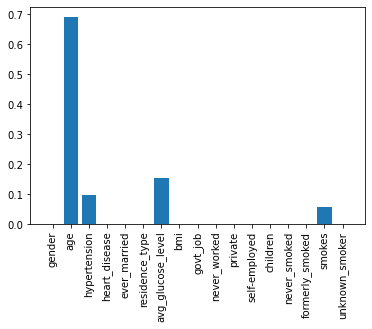

In [70]:
# Plotting the importance of each feature
plt.figure()
plt.bar(features, model.feature_importances_)
plt.xticks(rotation=90)
plt.show()

We see that the most important features seems to be ```age```, ```avg_glucose_level```, and ```hypertension```. The model does not indicate that ```smoking``` or ```bmi``` is important, which is interesting.

For these features we try plotting PD plots to see the marginal effects the features have on the predicted outcome of the balanced random forest. The PD plots shows what the marginal effect on the stroke prediction is for a specific value of a given feature. The assumptions behind using this method is that the features are not correlated. This is not the case. From the correlation plot we saw that ```age``` is highly correlated with ```ever_married```, ```children```, ```bmi``` and other features, for example. The solution to this problem is using ALE plots instead, but due to time limitations we will not do this in this project. We also plot the individual conditional expectation curves to make sure no effects are hidden by the aggregated PD curve.

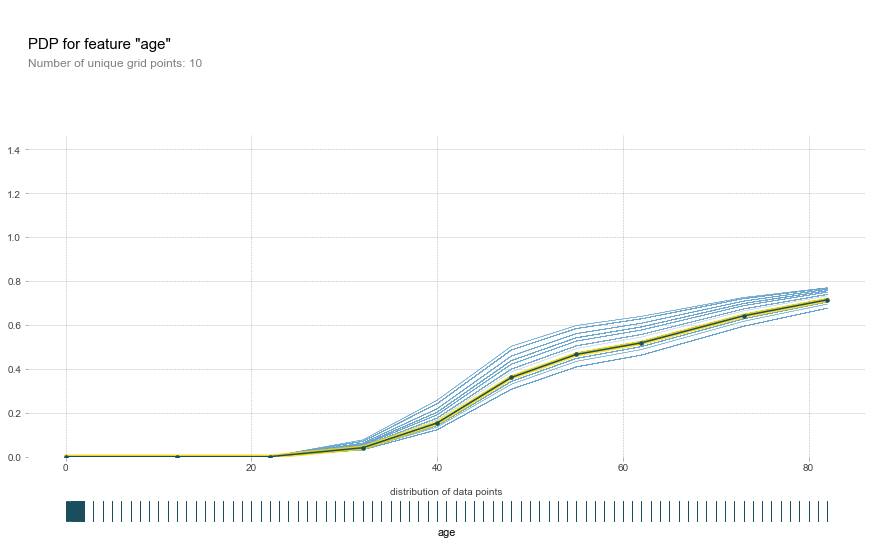

In [71]:
# PDP plot for Age
pdp_age = pdp.pdp_isolate(model = model, dataset = stroke_clean, model_features = features, feature = "age")
fig, axes = pdp.pdp_plot(pdp_age, "age", plot_lines = True, plot_pts_dist = True)

We see that for age, it seems like the general trend is that the chance of having a stroke increases with age in the model. This seems reasonable based on the data. 

In [ ]:
# PDP plot for average glucose level
pdp_glucose = pdp.pdp_isolate(model = model, dataset = stroke_clean, model_features = features, feature = "avg_glucose_level")
fig, axes = pdp.pdp_plot(pdp_glucose, "avg_glucose_level", plot_lines = True, plot_pts_dist = True)

The PD plot for ```avg_glucose_levels``` shows the same trend as for ```age```: the higher your glucose levels, the bigger is the chance of predicting a stroke. The increase in probability starts at 120 and ends at 175, before staying constand for average glucose levels above this. We see that we have less data with high glucose levels, which menas that the values there are less certain.

In [ ]:
# PDP plot for hypertension
pdp_hyp = pdp.pdp_isolate(model = model, dataset = stroke_clean, model_features = features, feature = "hypertension")
fig, axes = pdp.pdp_plot(pdp_hyp, "hypertension", plot_lines = True)

For ```hypertension```, the general trend seems to be that the presence of hypertension increases the chance of a stroke prediction.

### Local Methods

We will use LIME to explain some of the individual predictions of the xgboost model. LIME builds a local interpretable model which is a good approximation of the xgboost's predictions locally. From this learned method we can get an insight into which features are most important for certain predictions. We choose 4 observations from the test set, one from each square of the confusion matrix. This way we can try to understand why some of the observations are correctly classified, while others are not. This can help us further understand how the method works and maybe how it can be improved.

In [ ]:
# Creating an explainer
explainer = LimeTabularExplainer(
    training_data = np.array(X_train.iloc[:,:]),
    training_labels = np.array(y_train.iloc[:]),
    feature_names = features,
    class_names = "stroke",
    mode = "classification"
)

In [ ]:
# Creating an instance
i = 1
obs = X_test.iloc[i, :]
true_class = y_test.iloc[i]
print(f"Observation no. {i} (true negative): ")
print("True class: ", true_class)
print("Predicted probabilities from model: ", model.predict_proba(X_test)[i])

# Displaying
exp = explainer.explain_instance(obs, model.predict_proba)
print(exp.as_pyplot_figure())

The first observation is from the class "no stroke", and is correctly predicted. We see that the main factors in the prediction is the persons low age, absence of hypertension, that the person has never worked and the absence of heart disease. The model increases the chances of stroke a little because the person has high glucose levels, which seems reasonable from what we know about strokes.

In [ ]:
# Choosing a second observation
i = 2
obs = X_test.iloc[i, :]
true_class = y_test.iloc[i]
print(f"Observation no. {i} (false positive): ")
print("True class: ", true_class)
print("Predicted probabilities from model: ", model.predict_proba(X_test)[i])
# Displaying
exp = explainer.explain_instance(obs, model.predict_proba)
print(exp.as_pyplot_figure())

The second observation is also from the class "no stroke", but is among the observations which are falsely labelled by "stroke" by the model. The main reasons is the persons high age and high glucose level. We see that the models prediction is based mostly based on age, which is alarming. The only pattern model might have learned is that you have a higher risk of having a stroke if you are old, thus are all old people labeled as having a "stroke", almost independent of other factors. The person has no hypertension or heart disease which would indicate a stroke.

In [ ]:
# Choosing a third observation
i = 10
obs = X_test.iloc[i, :]
true_class = y_test.iloc[i]
print(f"Observation no. {i} (true positive): ")
print("True class: ", true_class)
print("Predicted probabilities from model: ", model.predict_proba(X_test)[i])

# Displaying
exp = explainer.explain_instance(obs, model.predict_proba)
print(exp.as_pyplot_figure())

The third observation is from the class "stroke", and is correctly predicted. We see that outside of age, the only features speaking for a stroke is the presence of hypertension and that the person has never worked, which it is intuitively hard to connect to a higher risk of a stroke. It does not seem that the model manages to actually capture any other effects than age, and if this does not outbalance the explanation from the feature heart_disease, hypertension and avg_glucose_level, it will totally dominate the prediction.

In [ ]:
# Choosing the last observation
i = 543 # 213, 419
obs = X_test.iloc[i, :]
true_class = y_test.iloc[i]
print(f"Observation no. {i} (false negative): ")
print("True class: ", true_class)
print("Predicted probabilities from model: ", model.predict_proba(X_test)[i])

# Displaying
exp = explainer.explain_instance(obs, model.predict_proba)
print(exp.as_pyplot_figure())

The last observations is also from the class "stroke", but is falsely predicted by the xgboost. Here we see that the model cannot find any real reason, except for gender, to classify the observation as a "stroke", even though this is the case. We see again that age matters way to much for the model, which makes it unreliable. We also see that in this case, there is no presence of hypertension, heart disease, an abnormally large bmi or high glucose levels, which makes this a really hard case to predict with our given features. This could mean that given the features we have, we will not be able to correctly classify all people, as there is an element of randomness in the occurrence of stroke or that we simply do not have the right features or have managed to extract the right information from the data.

## Comparing the different models.
The results are summarized in the following table. For logistic regression, deep neural network and random forest the models are fitted and tuned with respect to accuracy, and for all other models the methods are tuned with respect to balanced_accuracy. The precision, recall and accuracy given in this table are the models that maximized this metric.

| Model | Tuning  | Precision  | Recall  | Accuracy | ROC-AUC |
|---|---|---|---|---|---|
| Logistic Regression  | Built-in CV | 0.113 | 0.837  | 0.730  | 0.854 |
| Deep Neural Network | - | 0.086 | 0.918 | 0.609 | - |
| Balanced Decision Tree  |  GridSearchCV | 0.074 | 0.959 | 0.522 | 0.732 |
| Random Forest | GridSearchCV | 0.080 | 0.041 | 0.943 | 0.598 |
| Weighted Random Forest | GridSearchCV |0.119 | 0.735 | 0.773 | 0.818
| Balanced Random Forest | GridSearchCV | 0.085 | 0.878 | 0.619 | 0.791 |
| Balanced Random Forest | BayesianSearchCV | 0.094 | 0.918 | 0.645 | 0.836 |
| XgBoost | GridSearchCV | 0.100 | 0.837 | 0.694 | 0.848 |
| XgBoost | BayesianSearchCV | 0.093 |0.878 | 0.654 | 0.850 |

How well each model performs depends on what metric one uses to evaluate the models. In practice, one should choose a metric beforehand and tune the models to optimize this metric. The ROC-AUC is probably the most interesting metric in our case. We can however conclude with a few things:

- The logistic regression perfroms surprisingly well, achieving the highest ROC-AUC of all the models. This is perhaps surprising as it is the simplest model and the parameter tuning is essentially automatic. Logistic regression is in many cases simpler to perform inference on, as there is more theory on this than the tree-based methods. Maybe this illustrates that tree-based models d
- The balanced random forest with bayesian search tuning performs better with respect to all metrics than the one tuned with grid search. This illustrates the importance of hyperparameter tuning. For XgBoost, there is not a large discrepancy between the two hyperparameter tuning apporaches. This either shows that we got "lucky" with our gridsearch, or that XgBoost is not as sensitive to hyperparameters as the balanced random forest.
- Of the tree-based models, XgBoost performs the best with respect to ROC-AUC, and balanced random forest performs slighlty better than the weighted random forest. Weighted random forest might perform better if we had tuned it with a bayesian search, similar to the balanced random forest.
- It is difficult to perform a quantitative analysis of computational time of the different models. That would probably require a separate project. Qualitatively, we can say that the computational time increases roughly in the same order as the methods in the table, with logistic regression being the least computationally expensive and XgBoost being the most computationally expensive. Furthermore, the Bayesian search is drastically more expensive than grid search when considering how many model fits each of the models perform. Bayesian search is perhaps more suited for models where the model fitting time is larger than in this project.